In [1]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp

In [2]:
df = pd.read_csv("../../Data/MSCI_World_Data.csv")
df_diff = dp.difference_over_variables(df)
df_diff['timestamp'] = pd.to_datetime(df_diff['timestamp'])

In [3]:
df_diff

,timestamp,CL1,M1WO,SXXT,SPX,NKY,SPTR,EUR003M,FEDL01,GC1,V2X,MOVE,VIX,USYC2Y10,VXJ
0,2000-01-05,-0.025368,-0.013681,-0.028356,0.001920,0.000000,0.002008,-0.002,0.03,-0.005656,3.484005,4.669927,3.273743,3.386084,3.258097
1,2000-01-06,-0.005232,-0.011378,-0.006598,0.000955,0.000000,0.001155,-0.010,0.13,0.001063,3.439777,4.655958,3.247658,3.072693,3.296207
2,2000-01-07,-0.022858,0.023399,0.031469,0.026730,-6.583663,0.026730,-0.009,0.07,0.001769,3.312002,4.583027,3.078233,2.747271,3.247658
3,2000-01-10,0.018409,0.011027,0.015271,0.011128,6.583663,0.011147,-0.005,0.13,-0.000707,3.309448,4.576050,3.077773,2.513656,3.247658
4,2000-01-11,0.043623,-0.003420,-0.004971,-0.013149,-3.338158,-0.013119,-0.002,-0.11,0.005995,3.330775,4.615418,3.113515,2.917771,3.151881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6733,2025-10-27,-0.003094,0.010805,0.004416,0.012215,0.592428,0.012220,0.012,0.01,-0.028695,2.793794,4.202750,2.759377,3.889532,3.425890
6734,2025-10-28,-0.019102,0.001684,-0.000087,0.002285,3.717267,0.002290,-0.010,0.00,-0.008961,2.799547,4.209160,2.798500,3.879087,3.279406
6735,2025-10-29,0.005471,-0.000275,-0.000449,-0.000044,-3.842365,-0.000037,-0.008,0.00,0.004403,2.835241,4.185860,2.828496,3.862139,3.330775
6736,2025-10-30,0.001487,-0.009830,-0.001306,-0.009954,-4.115259,-0.009948,-0.016,-0.25,0.008050,2.825798,4.202900,2.827905,3.880863,3.249987


In [8]:
from hmmlearn.hmm import GaussianHMM

variable   = 'M1WO'
n_states   = 2
start_date = '2020-02-28'
end_date   = df_diff['timestamp'].max()

# Use 'ME' instead of deprecated 'M'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

state_cols = []   # collect Series here

for t in date_range:
    print(t)
    df_cur  = df_diff.loc[df_diff['timestamp'] <= t, ['timestamp', variable]]
    returns = df_cur[variable].to_numpy().reshape(-1, 1)
    if returns.shape[0] < n_states:
        continue

    # For 1-D data, 'diag' is simpler/faster and helps convergence
    model = GaussianHMM(n_components=n_states, covariance_type='diag',
                        n_iter=1000, random_state=42)
    model.fit(returns)
    z = model.predict(returns).astype(int)
    r = returns.ravel()

    # map states to a consistent convention (1=bull, 0=bear)
    eps = 1e-8
    means, stds = [], []
    for k in range(n_states):
        rk = r[z == k]
        if rk.size == 0:
            means.append(0.0)
            stds.append(1.0)     # neutral placeholder so score=0
        else:
            means.append(rk.mean())
            stds.append(rk.std() + eps)
    scores = np.array(means) / np.array(stds)
    bull_state = int(scores.argmax())
    z_mapped = (z == bull_state).astype(int)

    # build a full-length Series for this horizon, no column insert
    col = f"state_{t.strftime('%Y-%m')}"
    s = pd.Series(np.nan, index=df_diff.index, name=col, dtype='float')
    s.loc[df_diff['timestamp'] <= t] = z_mapped
    state_cols.append(s)

# single concat -> no fragmentation
if state_cols:
    df_diff = pd.concat([df_diff] + state_cols, axis=1)


2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00
2020-03-22 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-28 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00


In [9]:
len(date_range)

2073

In [10]:
import numpy as np
import pandas as pd

# 1) collect and sort your state columns by their horizon date
state_cols = [c for c in df_diff.columns if c.startswith('state_')]

def _parse_hz(c):
    s = c.split('state_')[1]
    dt = pd.to_datetime(s, format='%Y-%m', errors='coerce')
    if pd.isna(dt):
        dt = pd.to_datetime(s, format='%Y-%m-%d', errors='coerce')
    return dt

state_cols = sorted(state_cols, key=_parse_hz)

# 2) for each row (date), look across horizons and count switches
import numpy as np
import pandas as pd

# Only keep numeric values (0, 1) and NaNs
S = df_diff[state_cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)

def count_switches(row):
    # valid indices where we have both 0/1
    valid = np.isfinite(row)
    if valid.sum() <= 1:
        return 0
    
    # take only valid sequence
    seq = row[valid].astype(int)
    # compute number of adjacent flips
    switches = np.sum(seq[1:] != seq[:-1])
    return int(switches)

switch_counts = np.apply_along_axis(count_switches, 1, S)
df_diff["label_switches_across_horizons"] = switch_counts


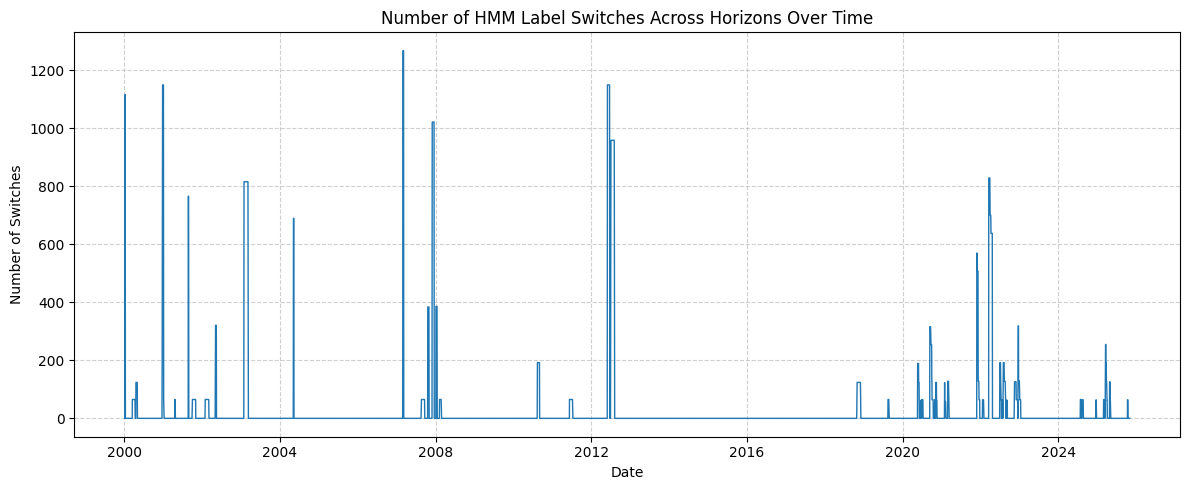

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure the timestamp column is a datetime
df_diff["timestamp"] = pd.to_datetime(df_diff["timestamp"])

plt.figure(figsize=(12, 5))
plt.plot(df_diff["timestamp"], df_diff["label_switches_across_horizons"], linewidth=1)
plt.title("Number of HMM Label Switches Across Horizons Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Switches")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Transition matrix (rows sum to 1):
[[0.98708227 0.01291773]
 [0.04166358 0.95833642]]
Model converged: True
Converged in 40 iterations (tol = 0.01 )
State means: [ 0.00071555 -0.00128752]
State stds:  [0.00636463 0.0172233 ]
Bull state: 0, Bear state: 1


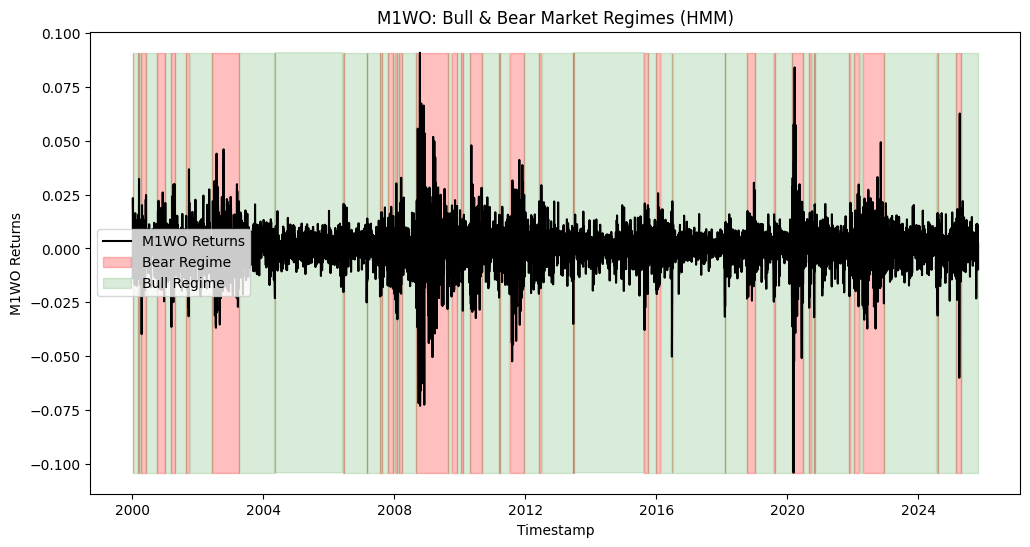

In [12]:
df = dp.create_classification_data(quiet=False)

In [13]:
returns = df_diff[variable].to_numpy().reshape(-1, 1)